# Notebook de Desenvolvimento

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("icefire", as_cmap=True)
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Limpeza

In [2]:
df = pd.read_csv('tweets.csv')
df.head()

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,Periga o Argenta chamar o Simon pra responder ...,NaN
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,RT @WinstonLing Segue o link para assistirem o...,1.0
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   author_id      3000 non-null   object 
 1   created_at     3000 non-null   object 
 2   id             3000 non-null   object 
 3   lang           3000 non-null   object 
 4   retweet_count  3000 non-null   int64  
 5   text           3000 non-null   object 
 6   sinal          1372 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 164.2+ KB


In [4]:
df = df[['text', 'sinal']]
df.head()

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,Periga o Argenta chamar o Simon pra responder ...,NaN
2,RT @WinstonLing Segue o link para assistirem o...,1.0
3,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


In [5]:
df = df.dropna(axis=0)
df.head()

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1.0
2,RT @WinstonLing Segue o link para assistirem o...,1.0
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0
5,@EduardoLeite_ 🤡,0.0
6,Nós já governamos o Rio Grande Sul com @olivio...,0.0


In [6]:
df.sinal = df.sinal.astype('int64')
df.head()

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1
2,RT @WinstonLing Segue o link para assistirem o...,1
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0
5,@EduardoLeite_ 🤡,0
6,Nós já governamos o Rio Grande Sul com @olivio...,0


In [7]:
df.shape

(1372, 2)

In [8]:
df.duplicated().sum()

253

In [9]:
df = df.drop_duplicates()
df.head()

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1
2,RT @WinstonLing Segue o link para assistirem o...,1
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0
5,@EduardoLeite_ 🤡,0
6,Nós já governamos o Rio Grande Sul com @olivio...,0


In [10]:
df.shape

(1119, 2)

In [11]:
df = df.reset_index(drop=True)
df.head()

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1
1,RT @WinstonLing Segue o link para assistirem o...,1
2,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0
3,@EduardoLeite_ 🤡,0
4,Nós já governamos o Rio Grande Sul com @olivio...,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1119 non-null   object
 1   sinal   1119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.6+ KB


In [13]:
df = df.rename(columns={'text':'tweet', 'sinal':'sentiment'})
df.head()

,tweet,sentiment
0,RT @EdegarPretto O meu candidato vice-governad...,1
1,RT @WinstonLing Segue o link para assistirem o...,1
2,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0
3,@EduardoLeite_ 🤡,0
4,Nós já governamos o Rio Grande Sul com @olivio...,0


## 2. Modelagem

In [14]:
def tokenize(text):
    # make all text lowercase 
    text = text.lower()

    # remove all type of punctuations 
    text = re.sub(f'[^a-z0-9]',' ', text)

    # tokenize the text
    tokens = word_tokenize(text)

    # lemmatize the text
    tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens]

    # remove stopwords
    tokens = [w for w in tokens if w not in stopwords.words('portuguese')]
    
    return tokens

def plot_results(y_test, y_pred):
    # matrix de confusão
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", cmap="icefire")
    plt.show()
    
    # métricas da classificação 
    print(classification_report(y_test, y_pred))

In [15]:
X = df['tweet']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

### KNN 

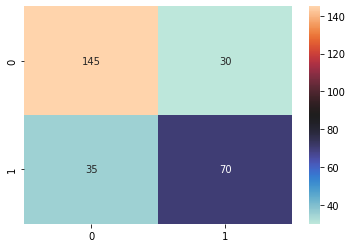

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       175
           1       0.70      0.67      0.68       105

    accuracy                           0.77       280
   macro avg       0.75      0.75      0.75       280
weighted avg       0.77      0.77      0.77       280



In [16]:
pipeline_knn = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('moc', KNeighborsClassifier())
])

pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)
plot_results(y_test, y_pred)

### Multi Layer Perceptron

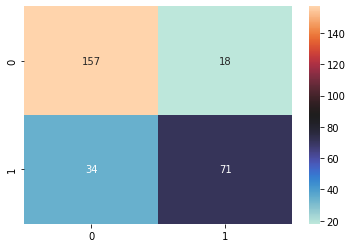

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       175
           1       0.80      0.68      0.73       105

    accuracy                           0.81       280
   macro avg       0.81      0.79      0.79       280
weighted avg       0.81      0.81      0.81       280



In [17]:
pipeline_mlp = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('moc', MLPClassifier())
])

pipeline_mlp.fit(X_train, y_train)
y_pred = pipeline_mlp.predict(X_test)
plot_results(y_test, y_pred)

### Random Forest Classifier

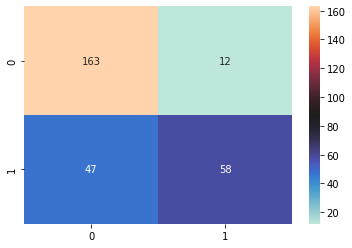

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       175
           1       0.83      0.55      0.66       105

    accuracy                           0.79       280
   macro avg       0.80      0.74      0.75       280
weighted avg       0.80      0.79      0.78       280



In [18]:
pipeline_rf = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('moc', RandomForestClassifier())
])

pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)
plot_results(y_test, y_pred)

### XGBoost

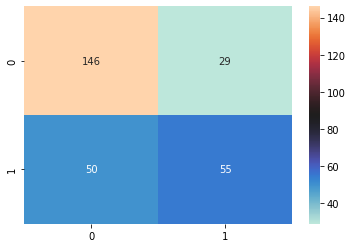

              precision    recall  f1-score   support

           0       0.74      0.83      0.79       175
           1       0.65      0.52      0.58       105

    accuracy                           0.72       280
   macro avg       0.70      0.68      0.68       280
weighted avg       0.71      0.72      0.71       280



In [19]:
pipeline_xg = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('moc', XGBClassifier())
])
pipeline_xg.fit(X_train, y_train)
y_pred = pipeline_xg.predict(X_test)
plot_results(y_test, y_pred)

### Naive Bayes

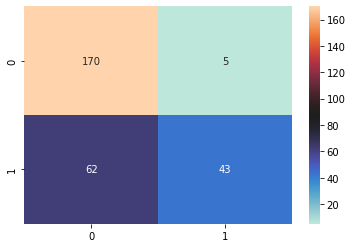

              precision    recall  f1-score   support

           0       0.73      0.97      0.84       175
           1       0.90      0.41      0.56       105

    accuracy                           0.76       280
   macro avg       0.81      0.69      0.70       280
weighted avg       0.79      0.76      0.73       280



In [20]:
pipeline_nb = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('moc', MultinomialNB())
])
pipeline_nb.fit(X_train, y_train)
y_pred = pipeline_nb.predict(X_test)
plot_results(y_test, y_pred)

### AdaBoost 

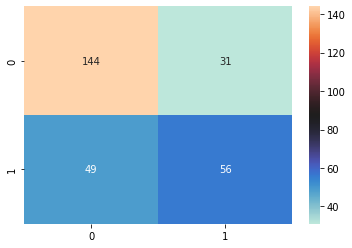

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       175
           1       0.64      0.53      0.58       105

    accuracy                           0.71       280
   macro avg       0.69      0.68      0.68       280
weighted avg       0.71      0.71      0.71       280



In [21]:
pipeline_ad = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('moc', AdaBoostClassifier())
    ])
pipeline_ad.fit(X_train, y_train)
y_pred = pipeline_ad.predict(X_test)
plot_results(y_test, y_pred)


### Regressão Logística

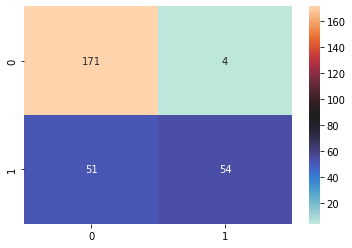

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       175
           1       0.93      0.51      0.66       105

    accuracy                           0.80       280
   macro avg       0.85      0.75      0.76       280
weighted avg       0.83      0.80      0.79       280



In [22]:
pipeline_lr = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('moc', LogisticRegression())
    ])
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)
plot_results(y_test, y_pred)

### Support Vector Machine

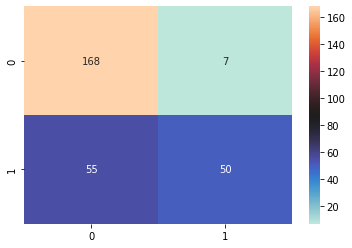

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       175
           1       0.88      0.48      0.62       105

    accuracy                           0.78       280
   macro avg       0.82      0.72      0.73       280
weighted avg       0.80      0.78      0.76       280



In [23]:
pipeline_sv = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('moc', SVC())
    ])
pipeline_sv.fit(X_train, y_train)
y_pred = pipeline_sv.predict(X_test)
plot_results(y_test, y_pred)

### Stacking

/Users/thiagomacedo/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


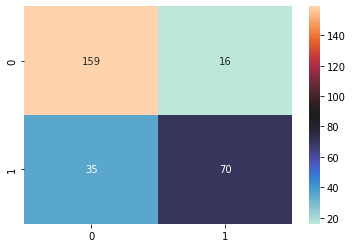

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       175
           1       0.81      0.67      0.73       105

    accuracy                           0.82       280
   macro avg       0.82      0.79      0.80       280
weighted avg       0.82      0.82      0.81       280



In [24]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('model', StackingClassifier(estimators=[('rf', RandomForestClassifier()), 
                                             ('ad', KNeighborsClassifier()), 
                                             ('xg', LogisticRegression())], 
                                             final_estimator=MLPClassifier()))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
plot_results(y_test, y_pred)

### Tuning 

In [25]:
X = df['tweet']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

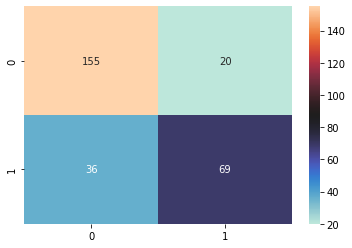

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       175
           1       0.78      0.66      0.71       105

    accuracy                           0.80       280
   macro avg       0.79      0.77      0.78       280
weighted avg       0.80      0.80      0.80       280



In [26]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(300, 200, 100, 50), max_iter=500, activation='tanh', solver='adam'))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
plot_results(y_test, y_pred)

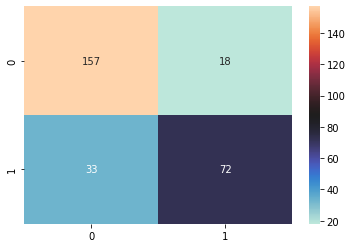

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       175
           1       0.80      0.69      0.74       105

    accuracy                           0.82       280
   macro avg       0.81      0.79      0.80       280
weighted avg       0.82      0.82      0.81       280



In [27]:
cv = StratifiedKFold()
param_grid = {
    'mlp__hidden_layer_sizes': [(300,200,100,50), (200,100,50), (100,50,30)],
    'mlp__max_iter': [500],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__alpha': [0.0001, 0.01]
}
clf = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plot_results(y_test, y_pred)